# **Importing Libraries**

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
import random
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
from sklearn.naive_bayes import MultinomialNB

# **Performing EDA in IMDB Dataset**

In [68]:
df = pd.read_csv("/content/DATASET IMBD 50K.csv")

In [69]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [70]:
df.isnull().sum()

,0
review,0
sentiment,0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [72]:
df.shape

(50000, 2)

In [73]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [74]:
df.duplicated().sum()

418

<ipython-input-75-1d41f95452c2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


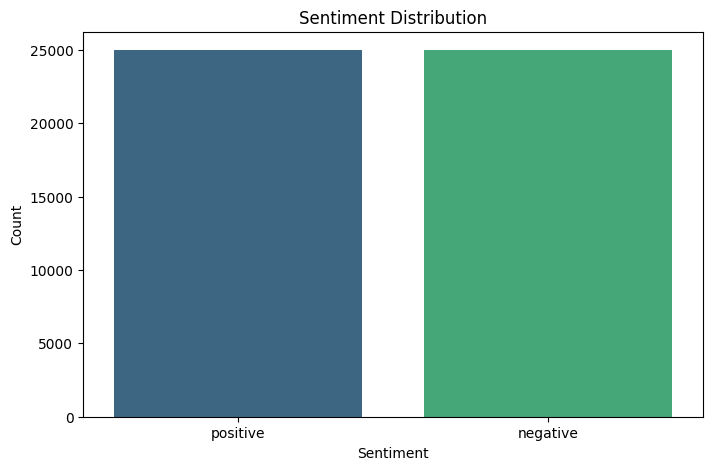

In [75]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<ipython-input-76-cd0f05bf4f7f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
<ipython-input-76-cd0f05bf4f7f>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')


Text(0.5, 0.98, 'Average word length in each text')

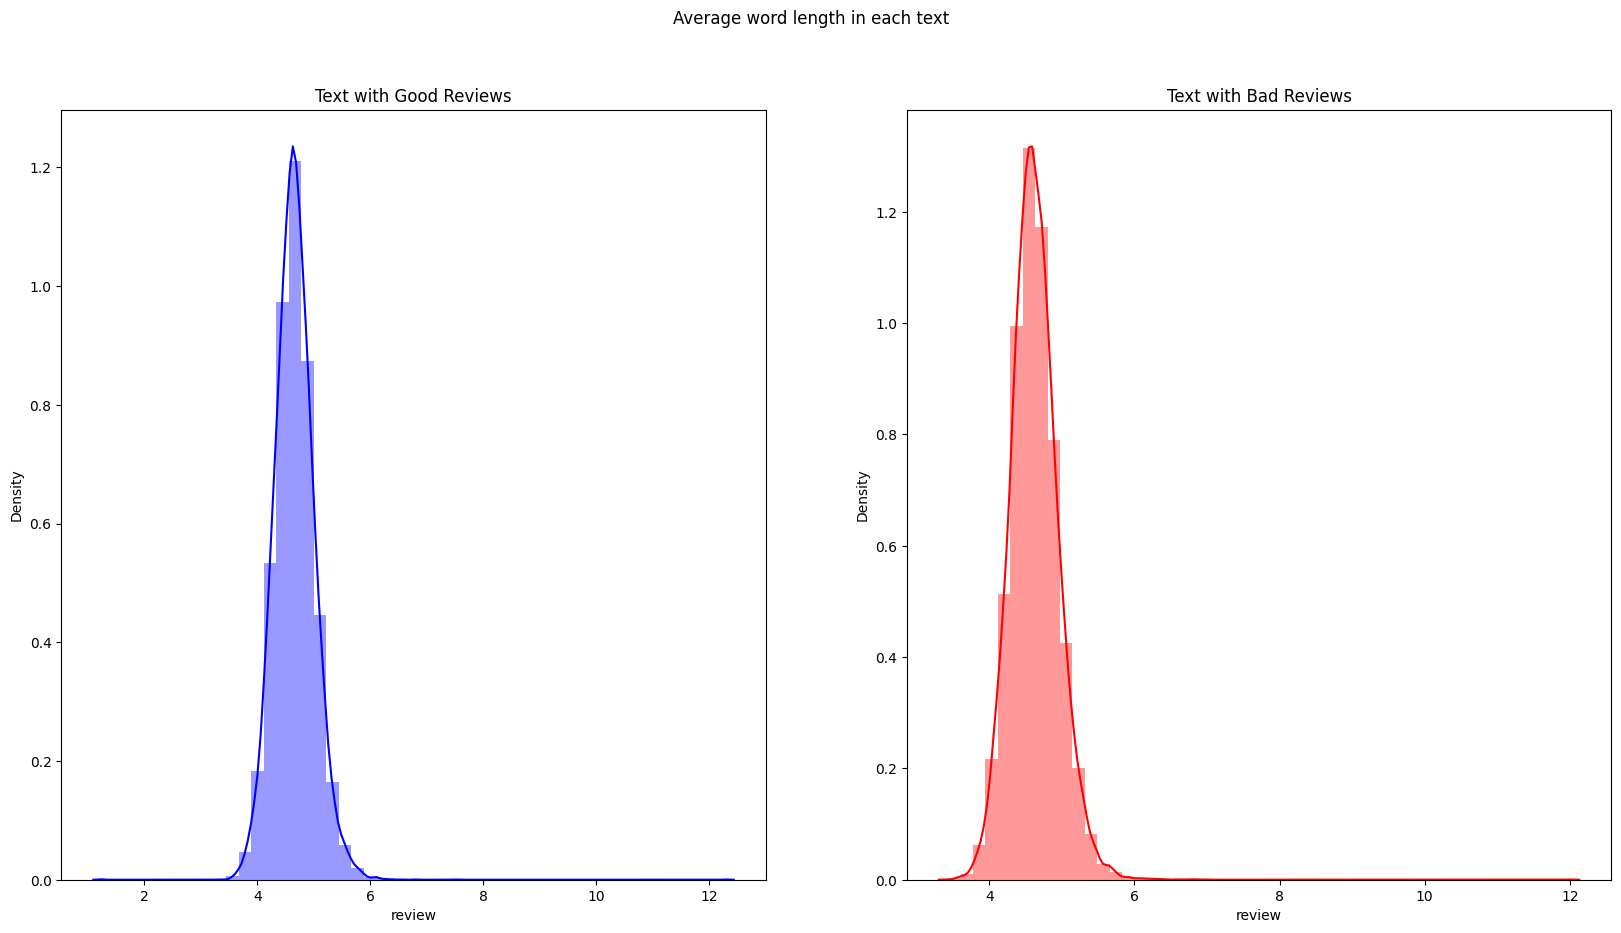

In [76]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['sentiment']=='positive']['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Text with Good Reviews')
word=df[df['sentiment']=='negative']['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')

In [77]:
# Generate the word clouds for positive and negative reviews

positive_reviews = " ".join(df[df['sentiment'] == 'positive']['review'])
negative_reviews = " ".join(df[df['sentiment'] == 'negative']['review'])

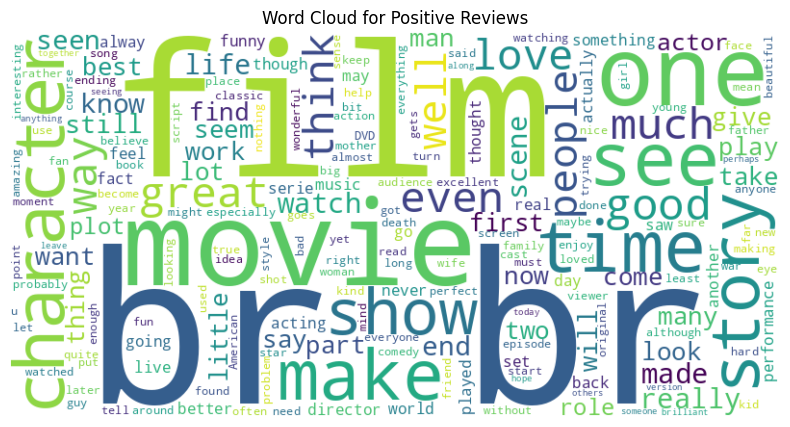

In [78]:
# Positive Reviews by using Wordcloud

positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

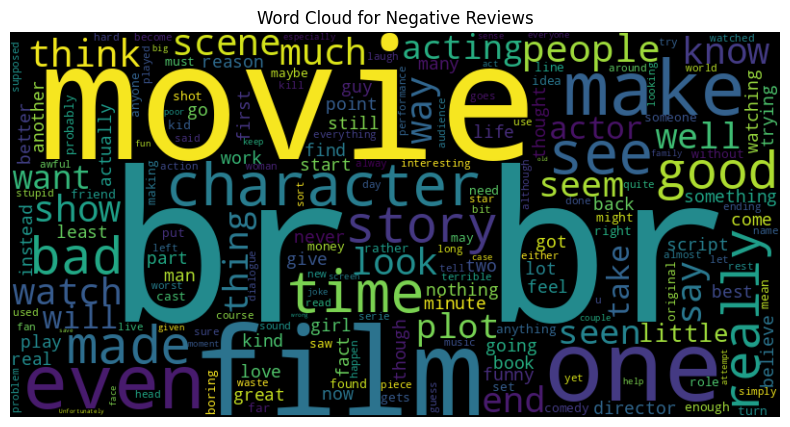

In [79]:
# Negative Reviews by using Wordcloud

negative_wc = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

In [80]:
# Convert a dataset Positive and negative into 1 and 0 integer form

df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


# **Use NLP for Text Preprocessing**

In [81]:
# using stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
# Remove HTML Strip and Special Characters
tag = random.randint(0, len(df)-1)
before_process = df.iloc[tag][0]

def process(a):
    a = re.sub('[,\.!?:()"]', '', a)
    a = re.sub('<.*?>', ' ', a)
    a = re.sub('http\S+', ' ', a)
    a = re.sub('[^a-zA-Z0-9]', ' ', a)
    a = re.sub('\s+', ' ', a)
    return a.lower().strip()

df['review'] = df['review'].apply(lambda a: process(a))
after_process = df.iloc[tag][0]

<ipython-input-82-a5b6be8a447d>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  before_process = df.iloc[tag][0]
<ipython-input-82-a5b6be8a447d>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  after_process = df.iloc[tag][0]


In [83]:
nltk.download('punkt_tab')
def sw_remove(a):
    words = nltk.tokenize.word_tokenize(a)
    filtered_list = [word for word in words if word not in stop_words]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda a: sw_remove(a))
after_removal = sw_remove(after_process)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [84]:
def stemmer(a):
  ps=nltk.porter.PorterStemmer()
  text= ' '.join([ps.stem(word) for word in a.split()])
  return text
df['review']=df['review'].apply(stemmer)

In [85]:
df.head(6)

,review,sentiment
0,one review mention watch 1 oz episod hook righ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1
5,probabl time favorit movi stori selfless sacri...,1


In [86]:
Y_train=df['sentiment']
Y_test=df['sentiment']

In [87]:
Y_test

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
49995,1
49996,0
49997,0
49998,0


In [88]:
norm_train_reviews=df.review[:40000]
norm_train_reviews[0]
norm_test_reviews=df.review[40000:]
norm_test_reviews[45005]

'read review watch piec cinemat garbag took least 2 page find somebodi els think appallingli unfunni montag acm humour 70 inde era least funni set sketch comedi ever seen till come along half skit alreadi done infinit better act monti python woodi allen say nice piec anim last 90 second highlight film would still get close sum mindless drivel ridden wast 75 minut semin comedi world semin realli mean semen scatolog humour world scat actual fece precursor joke mean handbook comedi tit bum odd beaver niceif pubesc boy least one hand free found playboy exist give break earli 70 way sketch comedi go back least ten year prior way could even forgiv film even made gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 lower scoreand recommend insomniac coma patientsor perhap peopl suffer lockjawtheir jaw would final drop open disbelief'

In [89]:
# Using Bag of Words

cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews = cv.fit_transform(norm_train_reviews[:40000])  # Process only 40000 reviews
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6605910)
BOW_cv_test: (10000, 6605910)


In [90]:
# Using Tfidf

tv=TfidfVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews[:40000])  # Process only 40000 reviews
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6605910)
Tfidf_test: (10000, 6605910)


In [91]:
lb=LabelBinarizer()
sentimentdata=lb.fit_transform(df['sentiment'])
print(sentimentdata.shape)

(50000, 1)


In [92]:
train_sentiment=sentimentdata[:40000]
test_sentiment=sentimentdata[40000:]
print(train_sentiment)
print(test_sentiment)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# **Apply Machine Learning Algorithm such as (Logistic Regression & Naive Bayes)**

In [93]:
lr = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=42)  # Increased max_iter
# For BOW
lr_bow = lr.fit(cv_train_reviews, train_sentiment)
# For Tfidf
lr_tfidf=lr.fit(tv_train_reviews,train_sentiment)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [94]:
print("Bag of Words :",lr_bow)
print("Tfidf :",lr_tfidf)

Bag of Words : LogisticRegression(C=1, max_iter=1000, random_state=42)
Tfidf : LogisticRegression(C=1, max_iter=1000, random_state=42)


In [95]:
# Bag of words Prediction
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
# Tfidf Prediction
lr_tfidf_predict=lr.predict(cv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


In [96]:
# Bag of Words Accuracy
lr_bow_accuracy=accuracy_score(test_sentiment,lr_bow_predict)
print("Accuracy of BOW: ",lr_bow_accuracy)
# Tfidf Accuracy
lr_tfidf_accuracy=accuracy_score(test_sentiment,lr_tfidf_predict)
print("Accuracy of Tfidf: ",lr_tfidf_accuracy)

Accuracy of BOW:  0.8612
Accuracy of Tfidf:  0.8612


In [97]:
# Classification Report of BOW
lr_bow_report=classification_report(test_sentiment,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)
# Classification Report of Tfidf
lr_tfidf_report=classification_report(test_sentiment,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.85      0.87      0.86      4993
    Negative       0.87      0.85      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

              precision    recall  f1-score   support

    Positive       0.85      0.87      0.86      4993
    Negative       0.87      0.85      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [98]:
# Confusion Matrix of BOW
bow_conf=confusion_matrix(test_sentiment,lr_bow_predict)
print("Confusion Matrix BOW: ",bow_conf)

# Confusion Matrix of Tfidf
tfidf_conf=confusion_matrix(test_sentiment,lr_tfidf_predict)
print("Confusion Matrix Tfidf: ",tfidf_conf)

Confusion Matrix BOW:  [[4357  636]
 [ 752 4255]]
Confusion Matrix Tfidf:  [[4357  636]
 [ 752 4255]]


In [99]:
multinv=MultinomialNB()
# For BOW
multinv_bow=multinv.fit(cv_train_reviews,train_sentiment)
print(multinv_bow)
# For Tfidf
multinv_tfidf=multinv.fit(tv_train_reviews,train_sentiment)
print(multinv_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [100]:
# Bag of words Prediction
multinv_bow_predict=multinv.predict(cv_test_reviews)
print(multinv_bow_predict)
# Tfidf Prediction
multinv_tfidf_predict=multinv.predict(cv_test_reviews)
print(multinv_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [101]:
# Bag of Words Accuracy
multinv_bow_accuracy=accuracy_score(test_sentiment,multinv_bow_predict)
print("Accuracy of BOW: ",multinv_bow_accuracy)
# Tfidf Accuracy
multinv_tfidf_accuracy=accuracy_score(test_sentiment,multinv_tfidf_predict)
print("Accuracy of Tfidf: ",multinv_tfidf_accuracy)

Accuracy of BOW:  0.8815
Accuracy of Tfidf:  0.8815


In [102]:
# Classification Report of BOW
multinv_bow_report=classification_report(test_sentiment,multinv_bow_predict,target_names=['Positive','Negative'])
print(multinv_bow_report)
# Classification Report of Tfidf
multinv_tfidf_report=classification_report(test_sentiment,multinv_tfidf_predict,target_names=['Positive','Negative'])
print(multinv_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.87      0.90      0.88      4993
    Negative       0.89      0.87      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

              precision    recall  f1-score   support

    Positive       0.87      0.90      0.88      4993
    Negative       0.89      0.87      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [103]:
# Confusion Matrix of BOW
bow_conf=confusion_matrix(test_sentiment,multinv_bow_predict)
print("Confusion Matrix BOW: ",bow_conf)

# Confusion Matrix of Tfidf
tfidf_conf=confusion_matrix(test_sentiment,multinv_tfidf_predict)
print("Confusion Matrix Tfidf: ",tfidf_conf)

Confusion Matrix BOW:  [[4480  513]
 [ 672 4335]]
Confusion Matrix Tfidf:  [[4480  513]
 [ 672 4335]]


# **Using Deep Learning LSTM Model**

In [104]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer

In [105]:
X_train, X_test, y_train, y_test = train_test_split(df["review"], df['sentiment'], test_size=0.2, random_state=42)

In [106]:
# Text Vectorization
max_words = 10000  # Maximum number of words to consider
max_len = 150      # Maximum length of each review

In [107]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [108]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [109]:
# Build the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [110]:
history=model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7735 - loss: 0.4539 - val_accuracy: 0.8749 - val_loss: 0.3143
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9179 - loss: 0.2175 - val_accuracy: 0.8771 - val_loss: 0.3017
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9481 - loss: 0.1498 - val_accuracy: 0.8745 - val_loss: 0.3320
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9637 - loss: 0.1047 - val_accuracy: 0.8701 - val_loss: 0.4477
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9750 - loss: 0.0764 - val_accuracy: 0.8655 - val_loss: 0.4653
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9766 - loss: 0.0733 - val_accuracy: 0.8627 - val_loss: 0.5197
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9812 - loss: 0.0555 - val_accuracy: 0.8625 - val_loss: 0.5116
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9886 - loss: 0.0380 - val_a

In [111]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [112]:
# Print classification report
print("LSTM Classifier Results:")
print(classification_report(y_test, y_pred))

LSTM Classifier Results:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4961
           1       0.85      0.88      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [113]:
# Calculate F1 Score and Accuracy
f1_lstm = f1_score(y_test, y_pred)
accuracy_lstm = accuracy_score(y_test, y_pred)
print(f"LSTM F1 Score: {f1_lstm}")
print(f"LSTM Accuracy: {accuracy_lstm}")

LSTM F1 Score: 0.86638729168697
LSTM Accuracy: 0.8629


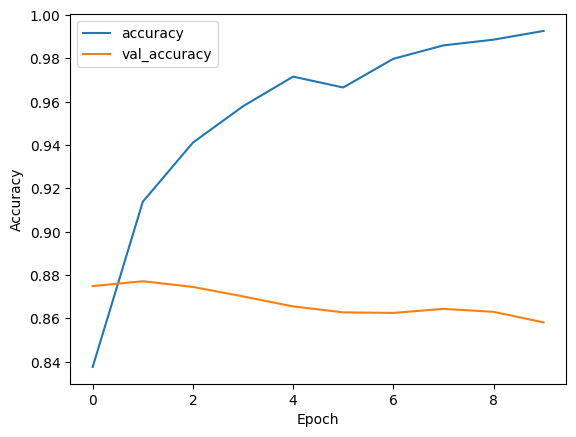

In [114]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Topic Modeling using LDA**

In [115]:
import pandas as pd
df=pd.read_csv("/content/DATASET IMBD 50K.csv")

In [116]:
import nltk
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

def stem(text):
    return stemmer.stem(text)

In [117]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS as stopwords

#print(stopwords)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len=4):
        if token not in stopwords: #and len(token) > 3:
            result.append(stem(token))
    return result

In [118]:
x=df['review']
processed_docs = []
for i in range(0, len(x)):
    processed_docs.append(preprocess(x[i]))

print(len(processed_docs))

dictionary = gensim.corpora.Dictionary(processed_docs)
print(len(dictionary))

index = 0
for key, value in dictionary.iteritems():
    print(key, value)
    index += 1
    if index > 9:
        break

50000
66065
0 accustom
1 agenda
2 agreement
3 appeal
4 aryan
5 audienc
6 away
7 bitch
8 brutal
9 call


In [119]:
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
print(len(dictionary))

16376


In [120]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 2),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 3),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 2),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 2),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 2),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 3),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 2),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 2),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1),

In [66]:
# Create the dictionary
id2word = dictionary

# Create the corpus with word frequencies
corpus = bow_corpus

# Build the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)


for index, topic in lda_model.print_topics(-1):
    print(f"Topic: {index} \nWords: {topic}")

Topic: 0 
Words: 0.018*"charact" + 0.015*"stori" + 0.009*"scene" + 0.008*"work" + 0.008*"time" + 0.007*"great" + 0.006*"plot" + 0.006*"good" + 0.006*"director" + 0.006*"perform"
Topic: 1 
Words: 0.022*"like" + 0.016*"watch" + 0.013*"time" + 0.013*"good" + 0.011*"act" + 0.010*"look" + 0.009*"think" + 0.009*"thing" + 0.009*"charact" + 0.009*"plot"
Topic: 2 
Words: 0.052*"comedi" + 0.038*"funni" + 0.037*"music" + 0.031*"song" + 0.022*"laugh" + 0.019*"danc" + 0.015*"joke" + 0.015*"anim" + 0.014*"sing" + 0.013*"humor"
Topic: 3 
Words: 0.015*"play" + 0.012*"role" + 0.011*"perform" + 0.009*"star" + 0.009*"best" + 0.008*"great" + 0.008*"actor" + 0.008*"cast" + 0.007*"year" + 0.006*"john"
Topic: 4 
Words: 0.014*"love" + 0.011*"play" + 0.011*"girl" + 0.009*"young" + 0.008*"wife" + 0.008*"father" + 0.008*"famili" + 0.008*"woman" + 0.007*"friend" + 0.007*"life"
Topic: 5 
Words: 0.033*"horror" + 0.014*"kill" + 0.010*"scene" + 0.010*"killer" + 0.009*"like" + 0.009*"blood" + 0.008*"look" + 0.008*"zom